Related tweet:
    https://twitter.com/sassorgsa/status/1138767881192333313

<div dir="rtl" lang="ar">لنفرض ان لدينا بيانات عن جميع سكان مدينة الرياض كـ **العمر**، **الوزن**، **الطول**، **اللون** (دعنا نسميها بالـ **خصائص** أو الأبعاد). ونرغب في تقسيم هذه البيانات إلى عدة مجموعات بحيث أن كل مجموعة ستحتوي على أشخاص متشابهين (أي يملكون خصائص مشابهة).</div>
<div dir="rtl" lang="ar">**كيف يمكننا القيام بذلك**؟</div>

<div dir="rtl" lang="ar">**الجواب**: يمكننا استخدام **خوارزمية التجميع**</div>


<div dir="rtl" lang="ar"># شرح خوارزمية التجميع (أو التصنيف) k-means</div>

<div dir="rtl" lang="ar">
تستخدم هذه الخوارزمية كثيراً في مجال **تعلم الآلة** و **علم البيانات** لتجميع "تقسيم" نقاط البيانات المتشابهه (المتقاربة) مع بعضها البعض في عدد معين من المجموعات.


في هذا الشرح، ولغرض تبسيط المفهوم:


- سنستخدم عدد صغير من البيانات لشرح كيف تعلم الخوارزمية بالتفصيل. 
- سنفترض بيانات وهمية لـ _الوزن_ و _الطول_ لعشرة اشخاص فقط. لاحظ **خاصيتين** فقط بمعنى كل نقطة في مدخلات البيانات ستحتوي على **بعدين**. عموماً، يمكن تطبيق نفس مفهوم الخوارزمية لأي عدد من الأبعاد.
- سنقوم بكتابة الخوارزمية من الصفر بدون إستخدام أي مكتبات برمجية جاهزة.

</div>

>  ملاحظة: يمكن للبيانات أن تكون عن أي شي معين و يمكن ان تحتوي على اكثر من بعد او خاصية، مثلاً: بيانات مرضى، أو قياسات درجات حرارة، أو أسعار اسهم، وغيرها

</div>


<div dir="rtl" lang="ar">
<meta charset="utf-8">

دعنا أولاً نبداً بـ بيانات الطول و الوزن للعشرة أشخاص، كالتالي: 

</div>

In [1]:
weights = [74, 77, 81, 76, 80, 91, 88, 93, 88, 92]           # الوزن بالكيلوغرام
heights = [179, 182, 181, 175, 174, 182, 178, 178, 174, 173] # الطول بالسنتيمتر

<div dir="rtl" lang="ar">
<meta charset="utf-8">

لنصور البيانات بشكل افضل، سنتعرضها في الرسم البياني التالي:
  
</div>

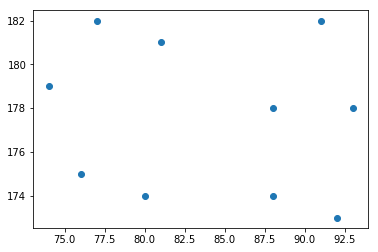

In [2]:
# أمر خاص بالنوتبوك لعرض الرسوم البيانية هنا مباشرة
%matplotlib inline
import matplotlib.pyplot as plt        # نستدعي مكتبة الرسوم البيانية
plt.scatter(weights, heights);         # نعطيها بيانات الطول و الوزن

<div dir="rtl" lang="ar">
<meta charset="utf-8">
من اجل تسهيل كتابة الكود، سنضع البيانات في متغير واحد. نسميه الأمثلة. كما يلي:

</div>

In [3]:
samples = [list(point) for point in zip(weights, heights)]
samples

[[74, 179],
 [77, 182],
 [81, 181],
 [76, 175],
 [80, 174],
 [91, 182],
 [88, 178],
 [93, 178],
 [88, 174],
 [92, 173]]

<div dir="rtl" lang="ar">
تحتاج خوارزمية التجميع أن تقوم بحساب المسافات بين النقاط، لذلك فيما يلي، سنكتب دالة لحساب المسافة بين نقطتين ما (وهي المسافة العادية، نفس المسافة الناتجة إذا استخدمنا المسطرة). هذي المسافة تسمى المسافة الإقليدية، ويتم حسابها بين نقطين $U=(u_1, u_2, ...,u_n)$ و $V=(v1, v2, ..., v_n)$ بحيث ان $n$ هو عدد الأبعاد في كل نقطة كما يلي: 
</div>

$$
\sqrt{\left(u_{1}-v_{1}\right)^{2}+\left(u_{2}-v_{2}\right)^{2}+\cdots+\left(u_{n}-v_{n}\right)^{2}}=\sqrt{\sum_{i=1}^{n}\left(u_{i}-v_{i}\right)^{2}}
$$

<div dir="rtl" lang="ar">
فيما يلي دالة بايثون لحساب المسافة:
</div>

In [4]:
def distance(u, v):
    """
    حساب المسافة الإقليدية بين نقطتين
    المسافة = square_root( (u0 - v0)^2 + (u1 - v1)^2) )
    
    u: [int, int], النقطة الأولى
    v: [int, int], النقطة الثانية
    """
    sum_ = sum( (u[i] - v[i])**2 for i in range(len(u)) ) # ناتج الجمع اللي تحت الجذر
    return sum_**(1/2)                                    # نأخذ الجذر للمجموع

<div dir="rtl" lang="ar">
سنكتب دالة تأخذ نقطة معينة (لنسميها النقطة الهدف) مع مجموعة نقاط أخرى (لنسميهم نقاط المنتصف)، وترجع النقطة (من نقاط المنتصف) الأقرب إلى النقطة الهدف. كما يلي:

</div>

In [5]:
def get_closer(target, *args):
    """
    حساب أي النقاط اقرب إلى النقطة الهدف
    
    target:  [int, int], النقطة الهدف
    *args: [[int, int]], مجموعة نقاط 
    """
    min_distance = float('inf')
    for point in args:
        d = distance(point, target)
        if d < min_distance:
            min_distance = d
            closer = point
    return closer

<div dir="rtl" lang="ar">
<meta charset="utf-8">
سنحتاج دالة أخرى تقوم بحساب نقطة المنتصف لمجموعة من النقاط، نستطيع كتابتها كما يلي:

</div>

In [6]:
def new_centers(*clusters):
    """
    حساب نقطة المنتصف لكل مجموعة من مجاميع المدخلات
    
    clusters: List[List[[int, int]]], قائمة من مجموعات النقاط
    """
    centers = []
    for c in clusters:
        n = max(len(c), 1) # avoid division by 0
        center = [sum(p[0] for p in c) / n, sum(p[1] for p in c) / n]
        centers.append(center)
    return centers

<div dir="rtl" lang="ar">
الآن وبعد أن قمنا بكتابة كل الدوال البرمجية التي تحتاجها خوارزمية التجميع، سنقوم بكتابة الخوارزمية كالآتي:
</div>

In [7]:
# k-means algorithm 'recursively'
def cluster(data, n_clusters=2, *seeds):

    
    # init centroids
    seeds = list(seeds) if seeds else [data[i] for i in range(n_clusters)]
        
    # clusters
    clusters = [[] for _ in range(n_clusters)]
    
    # add each point to its closest cluster
    for point in data:
        
        # which cluster's center is closest to point
        nearest = get_closer(point, *seeds)
        
        # get the index of the cluster that has its center closest to point
        nearest_cluster_index = seeds.index(nearest)
        
        # append p to that cluster
        clusters[nearest_cluster_index].append(point)

            
    # new centers
    new_seeds = new_centers(*clusters)


    # return when converge
    if seeds == new_seeds:
        return clusters, seeds

    # if not converge, recurse with new means as the seeds
    print("ITERATION:\n\tstarting seed: {}\n\tnew means: {}".format(seeds, new_seeds))
    return cluster(data, 2, *new_seeds)

In [8]:
# plot and print results
def report_result(centers, clusters):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'] # available colors in matplotlib
    n = len(clusters)
    colors = colors[:n]
    for i, clus, cent, col in zip(range(1, n+1), clusters, centers, colors):
        plt.scatter([c[0] for c in clus], [c[1] for c in clus], c=col, label=f"cluster {i}")
        plt.scatter(cent[0], cent[1], marker="x", label=f"centroid {i}")
        
    plt.grid();plt.legend(bbox_to_anchor = (2, 1));plt.show()

ITERATION:
	starting seed: [[74, 179], [77, 182]]
	new means: [[76.66666666666667, 176.0], [87.14285714285714, 178.28571428571428]]
ITERATION:
	starting seed: [[76.66666666666667, 176.0], [87.14285714285714, 178.28571428571428]]
	new means: [[77.6, 178.2], [90.4, 177.0]]
[[77.6, 178.2], [90.4, 177.0]]


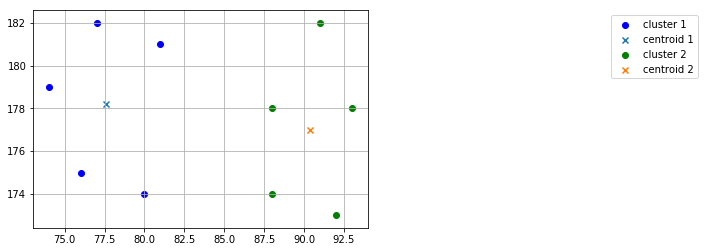

In [9]:
clusters, centers = cluster(samples, n_clusters=2)
print(centers)
report_result(centers, clusters)